In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
data_path = "/content/drive/MyDrive/Colab Notebooks/DL/"  # this is your drive

Mounted at /content/drive/


In [ ]:
import json

train_file = data_path + 'train_data/train_data.json'
val_file = data_path + 'train_data/val_data.json'
test_file = data_path + 'test_data/test_data.json'

with open(train_file, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

with open(val_file, 'r', encoding='utf-8') as f:
    val_data = json.load(f)

with open(test_file, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

print(f"训练集样本：{len(train_data)}，验证集样本：{len(val_data)},测试集样本：{len(test_data)}")

训练集样本：720，验证集样本：80,测试集样本：200


In [ ]:
train_data[0]['label2']

'I49.900;I49.100x001;I49.300x002;I10.x00x027;J18.900;K76.000'

In [ ]:
# 标签1（单标签分类）
label1_list = ["I10.x00x032", "I20.000", "I20.800x007", "I21.401", "I50.900x018"]
label12id = {label: idx for idx, label in enumerate(label1_list)}
id2label1 = {idx: label for label, idx in label12id.items()}

# 标签2（多标签分类）
label2_list = [
    "E04.101", "E04.102", "E11.900", "E14.900x001", "E72.101", "E78.500", "E87.600",
    "I10.x00x023", "I10.x00x024", "I10.x00x027", "I10.x00x028", "I10.x00x031", "I10.x00x032",
    "I20.000", "I25.102", "I25.103", "I25.200", "I31.800x004", "I38.x01", "I48.x01", "I48.x02",
    "I49.100x001", "I49.100x002", "I49.300x001", "I49.300x002", "I49.400x002", "I49.400x003",
    "I49.900", "I50.900x007", "I50.900x008", "I50.900x010", "I50.900x014", "I50.900x015",
    "I50.900x016", "I50.900x018", "I50.907", "I63.900", "I67.200x011", "I69.300x002",
    "I70.203", "I70.806", "J18.900", "J98.414", "K76.000", "K76.807", "N19.x00x002",
    "N28.101", "Q24.501", "R42.x00x004", "R91.x00x003", "Z54.000x033", "Z95.501", "Z98.800x612"
]
label22id = {label: idx for idx, label in enumerate(label2_list)}
id2label2 = {idx: label for label, idx in label22id.items()}

num_labels1 = len(label1_list)
num_labels2 = len(label2_list)
print(f"主要诊断编码种类：{num_labels1}，其他诊断编码种类：{num_labels2}")

主要诊断编码种类：5，其他诊断编码种类：53


In [ ]:
from torch.utils.data import Dataset
from transformers import BertTokenizer
import torch

# tokenizer = BertTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')


class MedicalDataset(Dataset):
    def __init__(self, data, tokenizer, label12id, label22id, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.label12id = label12id
        self.label22id = label22id
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text1 = item['text1']
        text2 = item['text2']

        # 编码文本对
        encoding = tokenizer(
            text1,
            text2,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt',
        )

        # 单标签编码
        label1 = self.label12id[item['label1']]

        # 多标签编码 -> multi-hot
        label2_raw = item['label2']
        label2_raw = label2_raw.split(";")

        label2 = [0] * len(self.label22id)
        for l in label2_raw:
            if l in self.label22id:
                label2[self.label22id[l]] = 1

        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding['label1'] = torch.tensor(label1, dtype=torch.long)
        encoding['label2'] = torch.tensor(label2, dtype=torch.float)

        return encoding

train_dataset = MedicalDataset(train_data, tokenizer, label12id, label22id)
val_dataset = MedicalDataset(val_data, tokenizer, label12id, label22id)
test_dataset = MedicalDataset(test_data, tokenizer, label12id, label22id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

In [ ]:
import torch

# 初始化计数器
label2_counts = torch.zeros(len(label22id), dtype=torch.float32)

# 统计每个标签的正类数量
for i in range(len(test_dataset)):
    sample = test_dataset[i]
    label2_counts += sample['label2']

print("Label2 Counts:", label2_counts)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Label2 Counts: tensor([ 2.,  0., 16.,  0.,  2.,  6.,  4.,  0.,  2.,  1.,  7.,  0., 23.,  1.,
         0., 32.,  3.,  1.,  3.,  4.,  0.,  1.,  3.,  4.,  3.,  3.,  0., 13.,
         1.,  2.,  3.,  1.,  0.,  0.,  1.,  4.,  2.,  0.,  1.,  6., 12.,  5.,
         1.,  6.,  1.,  0.,  2.,  4.,  0., 11.,  0.,  2.,  1.])


In [ ]:
# 打印前 5 个样本的 label2 及其对应的标签
for i in range(5):
    sample = test_dataset[i]
    label2_ids = (sample['label2'] == 1).nonzero(as_tuple=True)[0]  # 获取值为 1 的索引
    label2_labels = [id2label2[idx.item()] for idx in label2_ids]
    print(f"Sample {i}:")
    print(f"label1: {sample['label1']} -> {id2label1[sample['label1'].item()]}")
    print(f"label2 positive labels: {label2_labels}")
    print("---")

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Sample 0:
label1: 3 -> I21.401
label2 positive labels: ['I70.203']
---
Sample 1:
label1: 2 -> I20.800x007
label2 positive labels: ['I49.100x001']
---
Sample 2:
label1: 3 -> I21.401
label2 positive labels: ['I10.x00x032']
---
Sample 3:
label1: 1 -> I20.000
label2 positive labels: ['I70.806']
---
Sample 4:
label1: 0 -> I10.x00x032
label2 positive labels: ['E87.600']
---


In [ ]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from collections import Counter
from transformers import BertModel, BertConfig

# class MultiTaskBERT(nn.Module):
#     def __init__(self, model_name, num_labels1, num_labels2):
#         super(MultiTaskBERT, self).__init__()
#         self.bert = BertModel.from_pretrained(model_name)
#         hidden_size = self.bert.config.hidden_size

#         # 主要诊断（单标签）
#         self.classifier1 = nn.Linear(hidden_size, num_labels1)
#         # 其他诊断（多标签）
#         self.classifier2 = nn.Linear(hidden_size, num_labels2)

#         # self.log_sigma1 = nn.Parameter(torch.zeros(1))
#         self.log_sigma1 = nn.Parameter(torch.tensor[-1])
#         self.log_sigma2 = nn.Parameter(torch.zeros(1))

#     def forward(self, input_ids, attention_mask, token_type_ids):
#         outputs = self.bert(input_ids=input_ids,
#                             attention_mask=attention_mask,
#                             token_type_ids=token_type_ids)
#         pooled_output = outputs.pooler_output

#         logits1 = self.classifier1(pooled_output)
#         logits2 = self.classifier2(pooled_output)

#         return logits1, logits2

In [ ]:
class MultiTaskBERT(nn.Module):
    def __init__(self, pretrained_model_name, num_labels1, num_labels2):
        super().__init__()
        base_model = BertModel.from_pretrained(pretrained_model_name)
        config = BertConfig.from_pretrained(pretrained_model_name)
        self.shared_bert = nn.ModuleList(base_model.encoder.layer[:6])
        self.single_bert = nn.ModuleList([nn.ModuleList(base_model.encoder.layer[6:])[i] for i in range(6)])
        self.multi_bert = nn.ModuleList([nn.ModuleList(base_model.encoder.layer[6:])[i] for i in range(6)])
        self.embeddings = base_model.embeddings
        self.dropout = nn.Dropout(0.3)
        self.single_head = nn.Linear(768, num_labels1)
        self.multi_head = nn.Linear(768, num_labels2)
        # self.log_sigma1 = nn.Parameter(torch.zeros(1))
        self.log_sigma1 = nn.Parameter(torch.tensor([-1.0]))
        self.log_sigma2 = nn.Parameter(torch.zeros(1))

    def forward(self, input_ids, attention_mask, token_type_ids):
        embedding_output = self.embeddings(input_ids=input_ids, token_type_ids=token_type_ids)
        shared_output = embedding_output
        extended_attention_mask = self.get_extended_attention_mask(attention_mask)
        for layer in self.shared_bert:
            shared_output = layer(shared_output, extended_attention_mask)[0]
        single_output = shared_output
        for layer in self.single_bert:
            single_output = layer(single_output, extended_attention_mask)[0]
        multi_output = shared_output
        for layer in self.multi_bert:
            multi_output = layer(multi_output, extended_attention_mask)[0]
        single_cls = self.dropout(single_output[:, 0, :])
        multi_cls = self.dropout(multi_output[:, 0, :])
        single_logits = self.single_head(single_cls)
        multi_logits = self.multi_head(multi_cls)
        return single_logits, multi_logits

    def get_extended_attention_mask(self, attention_mask):
        if attention_mask.dim() == 2:
            extended_attention_mask = attention_mask[:, None, None, :]
            extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
            return extended_attention_mask
        return attention_mask

In [ ]:
def evaluate_acc(y_main_true, y_main_pred, y_other_true, y_other_pred):
    N = len(y_main_true)
    acc_total = 0
    for i in range(N):
        main_correct = 1 if y_main_pred[i] == y_main_true[i] else 0
        intersection = len(set(y_other_pred[i]) & set(y_other_true[i]))
        other_true_len = len(y_other_true[i]) if len(y_other_true[i]) > 0 else 1
        acc_i = 0.5 * main_correct + 0.5 * (intersection / other_true_len)
        acc_total += acc_i
    return acc_total / N

def calculate_label1_f1_micro(preds, trues):
    """
    计算单标签任务的 Micro-F1 分数
    preds: 预测的类别 (list or tensor)
    trues: 真实类别 (list or tensor)
    """
    preds = torch.tensor(preds)
    trues = torch.tensor(trues)
    tp = (preds == trues).sum().item()  # 真阳性
    fp = (preds != trues).sum().item()  # 假阳性（预测错误）
    fn = (preds != trues).sum().item()  # 假阴性（预测错误）

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

def calculate_label2_f1_micro(preds, trues):
    """
    计算多标签任务的 Micro-F1 分数
    preds: 预测的标签集合 (list of sets)
    trues: 真实的标签集合 (list of sets)
    """
    tp = sum(len(pred & true) for pred, true in zip(preds, trues))  # 所有真阳性
    fp = sum(len(pred - true) for pred, true in zip(preds, trues))  # 所有假阳性
    fn = sum(len(true - pred) for pred, true in zip(preds, trues))  # 所有假阴性

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

In [ ]:
def uncertainty_loss(logits1, label1, logits2, label2, log_sigma1, log_sigma2, pos_weights):
    criterion1 = nn.CrossEntropyLoss(reduction='mean')
    criterion2 = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weights.to(device))
    loss1 = criterion1(logits1, label1)
    loss2 = criterion2(logits2, label2)
    sigma1 = torch.exp(log_sigma1)
    sigma2 = torch.exp(log_sigma2)
    total_loss = (loss1 / (2 * sigma1**2) + loss2 / (2 * sigma2**2) +
                  log_sigma1 + log_sigma2)
    return total_loss, loss1, loss2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = MultiTaskBERT("hfl/chinese-roberta-wwm-ext", num_labels1, num_labels2)
model = MultiTaskBERT("bert-base-chinese", num_labels1, num_labels2)
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
optimizer = optim.AdamW([
    {'params': model.shared_bert.parameters(), 'lr': 1e-5},
    {'params': model.single_head.parameters(), 'lr': 3e-5},
    {'params': model.multi_head.parameters(), 'lr': 3e-5}
], weight_decay=1e-2)

train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_times = []
train_f1_label1_list = []  # 改为 F1
train_f1_label2_list = []  # 改为 F1
val_f1_label1_list = []    # 改为 F1
val_f1_label2_list = []    # 改为 F1
train_sigma1_list = []
train_sigma2_list = []
val_sigma1_list = []
val_sigma2_list = []

# # 计算 pos_weights
# label2_counts = torch.tensor([0] * 53, dtype=torch.float32)
# for batch in train_loader:
#     label2 = batch['label2']
#     label2_counts += label2.sum(dim=0)
# total_samples = len(train_dataset)
# pos_weights = (total_samples - label2_counts) / label2_counts
# pos_weights = torch.clamp(pos_weights, min=1.0, max=100.0)
# print("Pos Weights for Label2:", pos_weights)

# 计算 pos_weights
label2_counts = torch.tensor([0] * 53, dtype=torch.float32)
for batch in train_loader:
    label2 = batch['label2']
    label2_counts += label2.sum(dim=0)
print("Label2 Counts:", label2_counts)  # 调试输出
total_samples = len(train_dataset)
pos_weights = (total_samples - label2_counts) / (label2_counts + 1e-6)  # 避免除零
pos_weights = torch.clamp(pos_weights, min=1.0, max=500.0)  # 增大 max
print("Pos Weights for Label2:", pos_weights)

def train_epoch(model, loader, optimizer, pos_weights):
    model.train()
    total_loss = 0
    total_loss1 = 0
    total_loss2 = 0
    start_time = time.time()

    y_main_true, y_main_pred = [], []
    y_other_true, y_other_pred = [], []

    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        label1 = batch['label1'].to(device)
        label2 = batch['label2'].to(device)

        optimizer.zero_grad()
        logits1, logits2 = model(input_ids, attention_mask, token_type_ids)
        loss, loss1, loss2 = uncertainty_loss(logits1, label1, logits2, label2,
                                            model.log_sigma1, model.log_sigma2, pos_weights)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_loss1 += loss1.item()
        total_loss2 += loss2.item()

        preds1 = torch.argmax(logits1, dim=1).cpu()
        true1 = label1.cpu()
        preds2 = (torch.sigmoid(logits2) > 0.5).int().cpu()
        true2 = label2.int().cpu()

        preds2_set = [set([idx for idx, val in enumerate(p) if val == 1]) for p in preds2.tolist()]
        true2_set = [set([idx for idx, val in enumerate(t) if val == 1]) for t in true2.tolist()]

        y_main_pred.extend(preds1.tolist())
        y_main_true.extend(true1.tolist())
        y_other_pred.extend(preds2_set)
        y_other_true.extend(true2_set)

    avg_loss = total_loss / len(loader)
    elapsed_time = time.time() - start_time
    train_losses.append(avg_loss)
    train_times.append(elapsed_time)

    f1_label1 = calculate_label1_f1_micro(y_main_pred, y_main_true)
    f1_label2 = calculate_label2_f1_micro(y_other_pred, y_other_true)
    train_acc = evaluate_acc(y_main_true, y_main_pred, y_other_true, y_other_pred)

    train_accs.append(train_acc)
    train_f1_label1_list.append(f1_label1)
    train_f1_label2_list.append(f1_label2)

    sigma1 = torch.exp(model.log_sigma1).item()
    sigma2 = torch.exp(model.log_sigma2).item()
    train_sigma1_list.append(sigma1)
    train_sigma2_list.append(sigma2)

    preds2_positive = [len(p) for p in y_other_pred]
    print("Label2 Pred Positive Counts:", Counter(preds2_positive))

    print(f"Train Loss: {avg_loss:.4f} | Loss1: {total_loss1/len(loader):.4f} | Loss2: {total_loss2/len(loader):.4f} | "
          f"Train Acc: {train_acc:.4f} | Label1 F1: {f1_label1:.4f} | Label2 F1: {f1_label2:.4f} | "
          f"Sigma1: {sigma1:.4f} | Sigma2: {sigma2:.4f} | Time: {elapsed_time:.2f}s")

def eval_model(model, loader, pos_weights):
    model.eval()
    total_loss = 0
    total_loss1 = 0
    total_loss2 = 0

    y_main_true, y_main_pred = [], []
    y_other_true, y_other_pred = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            label1 = batch['label1'].to(device)
            label2 = batch['label2'].to(device)

            logits1, logits2 = model(input_ids, attention_mask, token_type_ids)
            loss, loss1, loss2 = uncertainty_loss(logits1, label1, logits2, label2,
                                                model.log_sigma1, model.log_sigma2, pos_weights)

            total_loss += loss.item()
            total_loss1 += loss1.item()
            total_loss2 += loss2.item()

            preds1 = torch.argmax(logits1, dim=1).cpu()
            true1 = label1.cpu()
            preds2 = (torch.sigmoid(logits2) > 0.5).int().cpu()
            true2 = label2.int().cpu()

            preds2_set = [set([idx for idx, val in enumerate(p) if val == 1]) for p in preds2.tolist()]
            true2_set = [set([idx for idx, val in enumerate(t) if val == 1]) for t in true2.tolist()]

            y_main_pred.extend(preds1.tolist())
            y_main_true.extend(true1.tolist())
            y_other_pred.extend(preds2_set)
            y_other_true.extend(true2_set)

    avg_loss = total_loss / len(loader)
    f1_label1 = calculate_label1_f1_micro(y_main_pred, y_main_true)
    f1_label2 = calculate_label2_f1_micro(y_other_pred, y_other_true)
    val_acc = evaluate_acc(y_main_true, y_main_pred, y_other_true, y_other_pred)

    val_losses.append(avg_loss)
    val_accs.append(val_acc)
    val_f1_label1_list.append(f1_label1)
    val_f1_label2_list.append(f1_label2)

    sigma1 = torch.exp(model.log_sigma1).item()
    sigma2 = torch.exp(model.log_sigma2).item()
    val_sigma1_list.append(sigma1)
    val_sigma2_list.append(sigma2)

    print(f"Val Loss: {avg_loss:.4f} | Loss1: {total_loss1/len(loader):.4f} | Loss2: {total_loss2/len(loader):.4f} | "
          f"Val Acc: {val_acc:.4f} | Label1 F1: {f1_label1:.4f} | Label2 F1: {f1_label2:.4f} | "
          f"Sigma1: {sigma1:.4f} | Sigma2: {sigma2:.4f}")

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Label2 Counts: tensor([ 49.,   0., 216.,   1.,  23., 139.,  36.,   7.,  40.,  15., 117.,   8.,
        205.,  79.,   2., 425.,  94.,   0.,  36.,  63.,  42.,  30.,  33.,  37.,
         79.,  37.,   3., 237.,  11.,  48.,  34.,  21.,   5.,   5.,  12.,  75.,
         41.,   1.,  57., 128., 151.,  50.,  35., 150.,  54.,   1.,  43.,  48.,
          1., 205.,   0.,  28.,   0.])
Pos Weights for Label2: tensor([ 13.6939, 500.0000,   2.3333, 500.0000,  30.3043,   4.1799,  19.0000,
        101.8571,  17.0000,  47.0000,   5.1538,  89.0000,   2.5122,   8.1139,
        358.9998,   1.0000,   6.6596, 500.0000,  19.0000,  10.4286,  16.1429,
         23.0000,  20.8182,  18.4595,   8.1139,  18.4595, 238.9999,   2.0380,
         64.4545,  14.0000,  20.1765,  33.2857, 143.0000, 143.0000,  59.0000,
          8.6000,  16.5610, 500.0000,  11.6316,   4.6250,   3.7682,  13.4000,
         19.5714,   3.8000,  12.3333, 500.0000,  15.7442,  14.0000, 500.0000,
          2.5122, 500.0000,  24.7143, 500.0000])


In [ ]:
label2_counts = torch.tensor([0] * 53, dtype=torch.float32)
for batch in test_loader:
    label2 = batch['label2']
print(label2)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.,

In [ ]:
def train_with_best_model_saving(model, train_loader, val_loader, optimizer, pos_weights, num_epochs):
    best_val_acc = 0.0  # 初始化最佳验证准确率
    best_model_path = data_path +  'best_model/best_model.pth'

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        train_epoch(model, train_loader, optimizer, pos_weights)
        eval_model(model, val_loader, pos_weights)

        # 使用验证准确率保存最佳模型
        current_val_acc = val_accs[-1]  # 获取最新的验证准确率
        if current_val_acc > best_val_acc:
            best_val_acc = current_val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved new best model with val_acc: {best_val_acc:.4f}")


In [ ]:
num_epochs = 16
total_start_time = time.time()

# 运行训练
train_with_best_model_saving(model, train_loader, val_loader, optimizer, pos_weights, num_epochs)

total_elapsed_time = time.time() - total_start_time
print(f"\nTraining complete! Total time: {total_elapsed_time:.2f}s")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
len(train_losses)

16

### 可视化

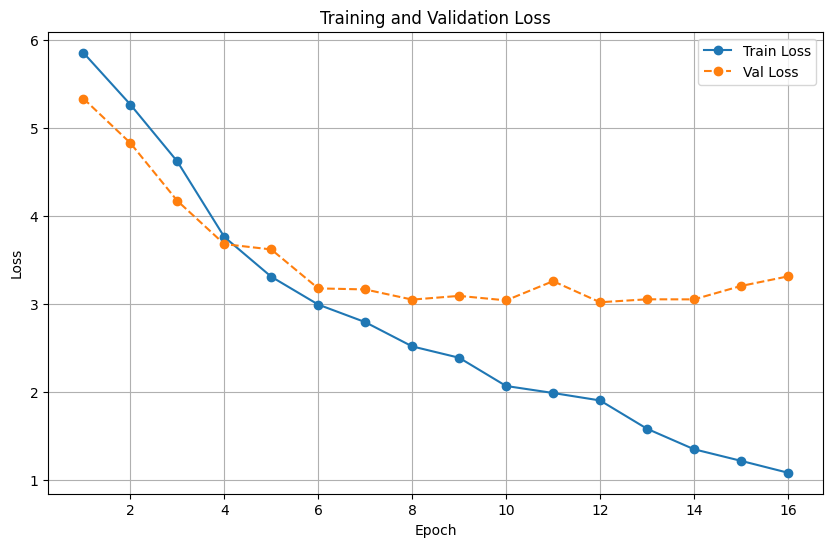

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(data_path + 'loss_curve.png')
plt.show()
plt.close()

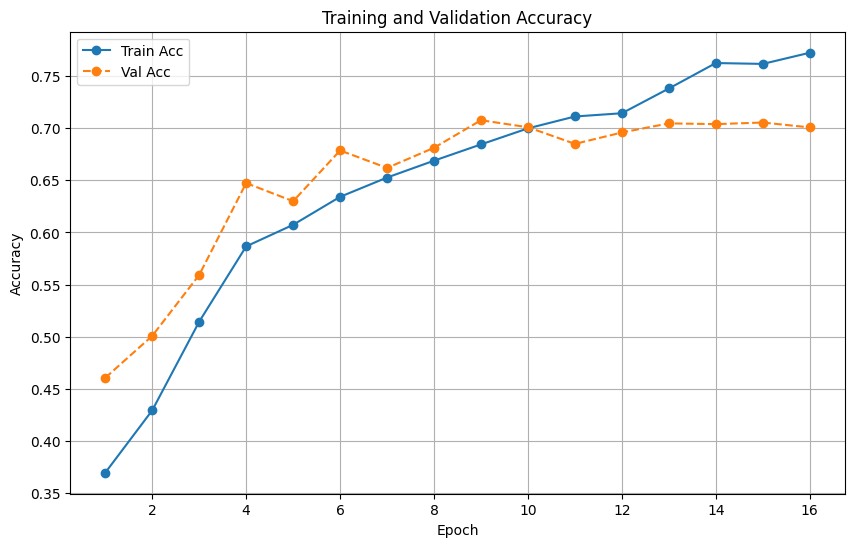

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accs, label='Train Acc', marker='o')
plt.plot(epochs, val_accs, label='Val Acc', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(data_path + 'accuracy_curve.png')
plt.show()
plt.close()

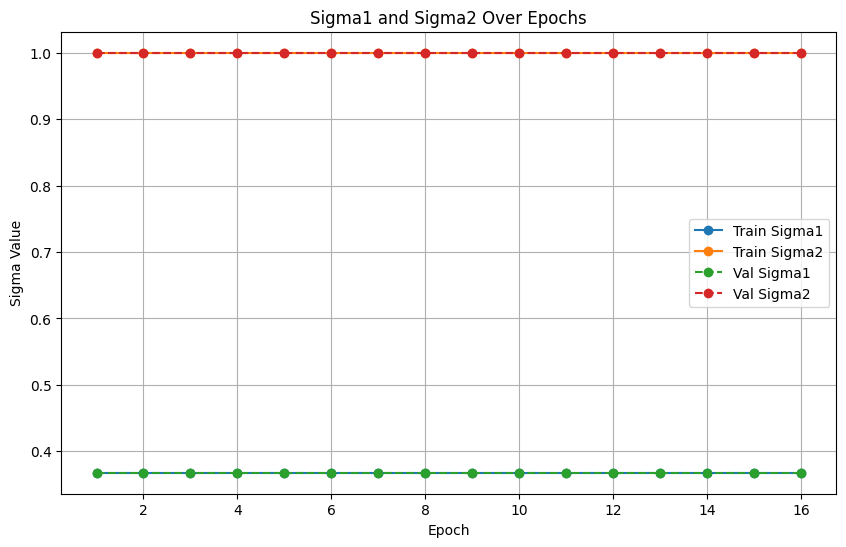

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_sigma1_list, label='Train Sigma1', marker='o')
plt.plot(epochs, train_sigma2_list, label='Train Sigma2', marker='o')
plt.plot(epochs, val_sigma1_list, label='Val Sigma1', marker='o', linestyle='--')
plt.plot(epochs, val_sigma2_list, label='Val Sigma2', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Sigma Value')
plt.title('Sigma1 and Sigma2 Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(data_path + 'sigma_curve.png')
plt.show()
plt.close()

### 模型测试

In [ ]:
def test_model(model, test_loader, pos_weights, num_test_epochs, device):
    # 存储最好的模型路径
    best_model_path = data_path + 'best_model/best_model.pth'

    # 加载验证时loss最小的模型参数
    model.load_state_dict(torch.load(best_model_path))
    model.to(device)

    # 存储每个epoch的accuracy
    test_accs = []

    print(f"\nStarting testing with {num_test_epochs} epochs...")

    for epoch in range(num_test_epochs):
        model.eval()
        y_main_true, y_main_pred = [], []
        y_other_true, y_other_pred = [], []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                label1 = batch['label1'].to(device)
                label2 = batch['label2'].to(device)

                logits1, logits2 = model(input_ids, attention_mask, token_type_ids)

                # 计算预测结果
                preds1 = torch.argmax(logits1, dim=1).cpu()
                true1 = label1.cpu()
                preds2 = (torch.sigmoid(logits2) > 0.5).int().cpu()
                true2 = label2.int().cpu()

                # 转换为集合形式用于evaluate_acc
                preds2_set = [set([idx for idx, val in enumerate(p) if val == 1])
                            for p in preds2.tolist()]
                true2_set = [set([idx for idx, val in enumerate(t) if val == 1])
                           for t in true2.tolist()]

                y_main_pred.extend(preds1.tolist())
                y_main_true.extend(true1.tolist())
                y_other_pred.extend(preds2_set)
                y_other_true.extend(true2_set)

        # 计算当前epoch的accuracy
        test_acc = evaluate_acc(y_main_true, y_main_pred, y_other_true, y_other_pred)
        test_accs.append(test_acc)

        print(f"Test Epoch {epoch + 1}/{num_test_epochs} | Accuracy: {test_acc:.4f}")

    # 计算平均accuracy
    avg_test_acc = np.mean(test_accs)
    print(f"\nTesting completed!")
    print(f"Average Test Accuracy across {num_test_epochs} epochs: {avg_test_acc:.4f}")
    #print(f"Individual epoch accuracies: {[f'{acc:.4f}' for acc in test_accs]}")

    # return avg_test_acc, test_accs
    return avg_test_acc

In [ ]:
import numpy as np
num_test_epochs = 10 # 你可以调整测试的epoch数量
# avg_test_acc, test_accs = test_model(model, test_loader, pos_weights, num_test_epochs, device)
avg_test_acc = test_model(model, test_loader, pos_weights, num_test_epochs, device)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


Starting testing with 10 epochs...


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Epoch 1/10 | Accuracy: 0.7125


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Epoch 2/10 | Accuracy: 0.7125


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Epoch 3/10 | Accuracy: 0.7125


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Epoch 4/10 | Accuracy: 0.7125


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Epoch 5/10 | Accuracy: 0.7125


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Epoch 6/10 | Accuracy: 0.7125


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Epoch 7/10 | Accuracy: 0.7125


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Epoch 8/10 | Accuracy: 0.7125


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Epoch 9/10 | Accuracy: 0.7125


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Test Epoch 10/10 | Accuracy: 0.7125

Testing completed!
Average Test Accuracy across 10 epochs: 0.7125


In [ ]:
# 清理缓存
torch.cuda.empty_cache()

# 可选：释放所有未使用的显存
torch.cuda.reset_peak_memory_stats()